In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   

import talib as ta 

print(ta.get_functions())
print(ta.get_function_groups())

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',

In [2]:
df1 = pd.read_csv("D:/quant_datas/etf/510050.csv")
df1=df1[['datetime', 'high', "low", "open", "close"]]
df1.index = pd.to_datetime(df1["datetime"])
df1 = df1[df1.index>=pd.to_datetime("2011-09-20")]
df1.drop('datetime', axis=1, inplace=True)

print(df1)

             high    low   open  close
datetime                              
2011-09-20  1.928  1.905  1.913  1.920
2011-09-21  1.976  1.909  1.917  1.969
2011-09-22  1.958  1.912  1.953  1.916
2011-09-23  1.909  1.876  1.889  1.902
2011-09-26  1.905  1.849  1.886  1.851
...           ...    ...    ...    ...
2023-12-25  2.976  2.962  2.968  2.970
2023-12-26  2.971  2.953  2.970  2.961
2023-12-27  2.970  2.947  2.961  2.964
2023-12-28  3.022  2.960  2.962  3.016
2023-12-29  3.027  3.007  3.012  3.017

[2984 rows x 4 columns]


In [3]:
from talib import RSI, BBANDS
up, mid, low = BBANDS(df1.close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(df1.close, timeperiod=14)

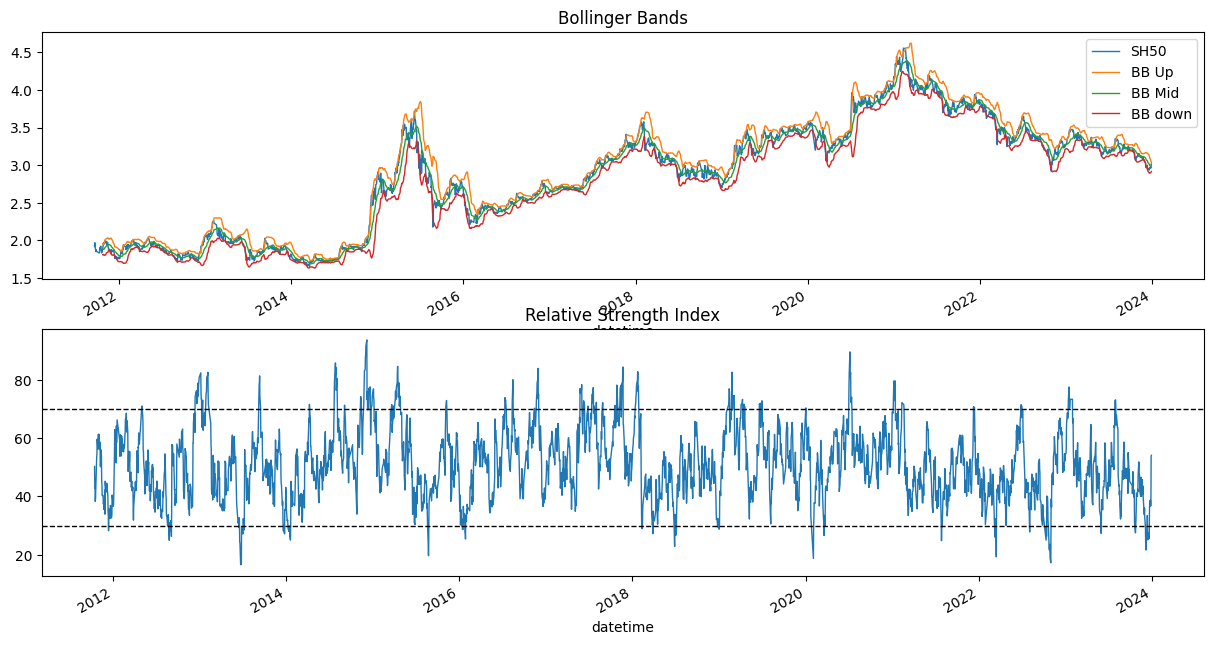

In [5]:
data = pd.DataFrame({'SH50': df1.close, 'BB Up': up, 'BB Mid': mid, 'BB down': low, 'RSI': rsi})
fig, axes= plt.subplots(nrows=2, figsize=(15, 8))
data.drop('RSI', axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')
data['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[1].axhline(70, lw=1, ls='--', c='k')
axes[1].axhline(30, lw=1, ls='--', c='k')

In [4]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1],
                observation_matrices = [1],
                initial_state_mean = 0,
                initial_state_covariance = 1,
                observation_covariance=1,
                transition_covariance=.01)

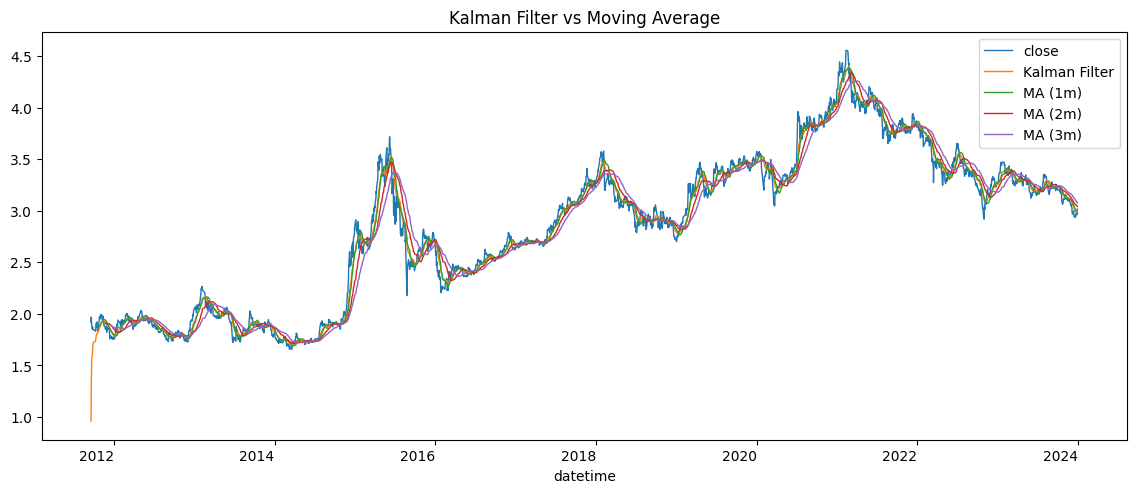

In [5]:
close_data = df1.close
state_means, _ = kf.filter(close_data)
close_data_smoothed = close_data.to_frame('close')
close_data_smoothed['Kalman Filter'] = state_means
for months in [1, 2, 3]:
    close_data_smoothed[f'MA ({months}m)'] = (close_data.rolling(window=months * 21).mean())
ax = close_data_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(14, 6), lw=1, rot=0)

In [6]:
signal = df1.close.pct_change().dropna()
signal

datetime
2011-09-21    0.025521
2011-09-22   -0.026917
2011-09-23   -0.007307
2011-09-26   -0.026814
2011-09-27    0.012426
                ...   
2023-12-25    0.000337
2023-12-26   -0.003030
2023-12-27    0.001013
2023-12-28    0.017544
2023-12-29    0.000332
Name: close, Length: 2983, dtype: float64

In [7]:
import pywt
pywt.families(short=False)
wavelet = "db6"
for i, scale in enumerate([.1]):
    coefficients = pywt.wavedec(signal, wavelet, mode='per')
    coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
    print(reconstructed_signal)
    signal.plot(color="b", alpha=0.5, label='original signal', lw=2, title=f'Threshold Scale: {scale:.1f}', ax=axes[i])
    # pd.Series(reconstructed_signal, index=signal.index).plot(c='k', label='DWT smoothing}', linewidth=1, ax=axes[i])

[ 0.0203107  -0.01649986 -0.00451572 ...  0.00776474 -0.00142627
 -0.00493049]


NameError: name 'axes' is not defined

In [46]:
from alphalens.utils import get_clean_factor_and_forward_returns, compute_forward_returns, get_clean_factor, quantize_factor
from alphalens.tears import create_full_tear_sheet
from alphalens.tears import create_returns_tear_sheet
from alphalens import performance

from random import random

In [49]:
HOLDING_PERIODS = (1, 5, 10)
QUANTILES = 5

df1['asset'] = 'SH50'

def Random(df):
    return random()

df1.loc[:, 'factor'] = df1.apply(Random, axis=1)

df2 = df1.reset_index()

df2 = df2.rename(columns={'datetime':'date'})
df2 = df2.set_index(['date', 'asset'], drop=True)

factor_data = df2.factor
# factor_data = factor_data[factor_data.index.levels[0]<=pd.to_datetime("2022-01-01")]
# close_data = df2.reset_index().rename(columns={'close':'SH50'})
# close_data = close_data[['datetime', 'SH50']].set_index('datetime')

close_data = df2.pivot_table(index='date', columns='asset', values='close')

# forward_returns = compute_forward_returns(factor_data, close_data, HOLDING_PERIODS, 20, True)

# factor_data = get_clean_factor(
#         factor_data,
#         close_data,
#         groupby=None,
#         groupby_labels=None,
#         quantiles=5,
#         bins=None,
#         binning_by_group=False,
#         max_loss=0.35,
#         zero_aware=False,
#     )

# initial_amount = float(len(factor_data.index))

# merged_data = forward_returns.dropna()

# merged_data["factor"] = factor_data

# quantile_data = quantize_factor(merged_data, 1, None, False, True, False)

# quantile_data

# binning_amount = float(len(merged_data.index))



# binning_amount
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data, prices=close_data, periods=HOLDING_PERIODS, quantiles=1)

alphalens_data

IC = performance.factor_information_coefficient(alphalens_data)


Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,,1D,5D,10D,factor,factor_quantile
date,asset,,,,,
2011-09-20,SH50,0.025521,-0.023958,-0.043750,0.998891,1
2011-09-21,SH50,-0.026917,-0.056882,-0.034027,0.219448,1
2011-09-22,SH50,-0.007307,-0.032359,-0.004697,0.773082,1
2011-09-23,SH50,-0.026814,-0.027340,0.003155,0.890493,1
2011-09-26,SH50,0.012426,-0.009724,0.038358,0.009545,1
...,...,...,...,...,...,...
2023-12-11,SH50,0.004354,-0.013731,-0.005358,0.265635,1
2023-12-12,SH50,-0.015338,-0.017006,-0.012671,0.094314,1
2023-12-13,SH50,-0.003725,-0.006095,0.003725,0.372666,1
